In [408]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

class DesignTool:
    def __init__(self):
        pass

    def get_blanket_space(self, sides, spacing, wall=True):
        self.sides = np.array(sides)
        self.ndim = len(self.sides)
        self.spacing = float(spacing)
        self.wall = wall
        print(f'Sides are {self.sides} with spacing of {self.spacing} m ({self.ndim} dimensions).')
        print(f'Overall system sizes are {self.sides * self.spacing} m')
        if self.wall:
            self.true_sides = self.sides + 2
        else:
            self.true_sides = self.sides
        self.voxels = np.zeros(self.true_sides)
        self.center = (np.array(self.true_sides) - 1) // 2
        # This is so center is at (0, 0, 0)
        self.side_coord = [np.linspace(-(int((side-1) / 2)) * self.spacing, int((side) / 2) * self.spacing, side) for side in self.true_sides]
        self.mesh = np.meshgrid(*self.side_coord, indexing='ij')
        # Barrier types: -1 = no barrier, 0 = surrounding wall, 1 -> N = custom
        self.barrier_type = np.zeros(self.true_sides).astype(int) - 1
        # Barrier types: 0 = default (diffusion the same everywhere), 1 -> N = custom defined locations
        self.special_space_type = np.zeros(self.true_sides).astype(int)

    def set_border_wall(self): 
        if self.ndim >= 1:
            self.barrier_type[0] = 0
            self.barrier_type[-1] = 0
        if self.ndim >= 2:
            self.barrier_type[:, 0] = 0
            self.barrier_type[:, -1] = 0
        if self.ndim >= 3:
            self.barrier_type[:, :, 0] = 0
            self.barrier_type[:, :, -1] = 0

    
    def draw2D(self):
        assert self.ndim == 2
        my_cmap = cm.get_cmap('tab10')
        my_cmap.set_under('w')
        plt.imshow(self.barrier_type, cmap=my_cmap, vmin=0)
    
    def draw3D(self, include_type=None, exclude_type=None):
        
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        barrier_types = set(np.unique(self.barrier_type))
        if include_type is not None: # Include takes precedence
            plot_types = barrier_types.intersection(set(include_type))
        elif exclude_type is not None:
            plot_types = barrier_types - set(exclude_type)
        else:
            plot_types = barrier_types
        
        for barrier_idx in plot_types:
            if barrier_idx >= 0:
                xs, ys, zs = [self.mesh[x][self.barrier_type == barrier_idx] for x in range(self.ndim)]
                ax.scatter(xs, ys, zs, s = 25, marker='s', alpha=0.02)
        ax.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs)))
        ax.set_xlim([self.side_coord[0][0], self.side_coord[0][-1]])
        ax.set_ylim([self.side_coord[1][0], self.side_coord[1][-1]])
        ax.set_zlim([self.side_coord[2][0], self.side_coord[2][-1]])
        # plt.title(f't = {self.cumulative_t:.3e} s')
        plt.grid(alpha=0.3)
        plt.show()

    def add_box(self, x, y, barrier_type, z=None, offsetx=None, offsety=None, offsetz=None):
        if self.ndim == 3:
            assert z is not None
        # Put a centered box
        center = self.center
        if offsetx is not None:
            center[0] += offsetx
        if offsety is not None:
            center[1] += offsety
        if offsetz is not None and self.ndim == 3:
            center[2] += offsetz
        xp = center[0] + int(x/2/self.spacing)
        xm = center[0] - int(x/2/self.spacing)
        yp = center[1] + int(y/2/self.spacing)
        ym = center[1] - int(y/2/self.spacing)

        if self.ndim == 2:
            print(xm, xp, ym, yp)
            self.barrier_type[[xp, xm], ym:yp+1] = barrier_type
            # self.barrier_type[xm, ym:yp+1] = barrier_type
            self.barrier_type[xm:xp+1, [ym, yp]] = barrier_type
            # self.barrier_type[xm:xp+1, yp] = barrier_type
        if self.ndim == 3:
            zp = center[2] + int(z/2/self.spacing)
            zm = center[2] - int(z/2/self.spacing)
            self.barrier_type[[xm, xp], ym:yp+1, zm:zp+1] = barrier_type
            self.barrier_type[xm:xp+1, [ym, yp], zm:zp+1] = barrier_type
            self.barrier_type[xm:xp+1, ym:yp+1, [zm, zp]] = barrier_type

In [409]:
a = DesignTool()

In [410]:
a.get_blanket_space([128, 64, 64], spacing=16e-9)

Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m


In [411]:
a.voxels.shape

(130, 66, 66)

In [412]:
a.center

array([64, 32, 32])

In [413]:
a.add_box(x=2e-6, y=0.8e-6, z=0.8e-6, barrier_type=3)

In [414]:
a.set_border_wall()

In [415]:
a.mesh[0].shape

(130, 66, 66)

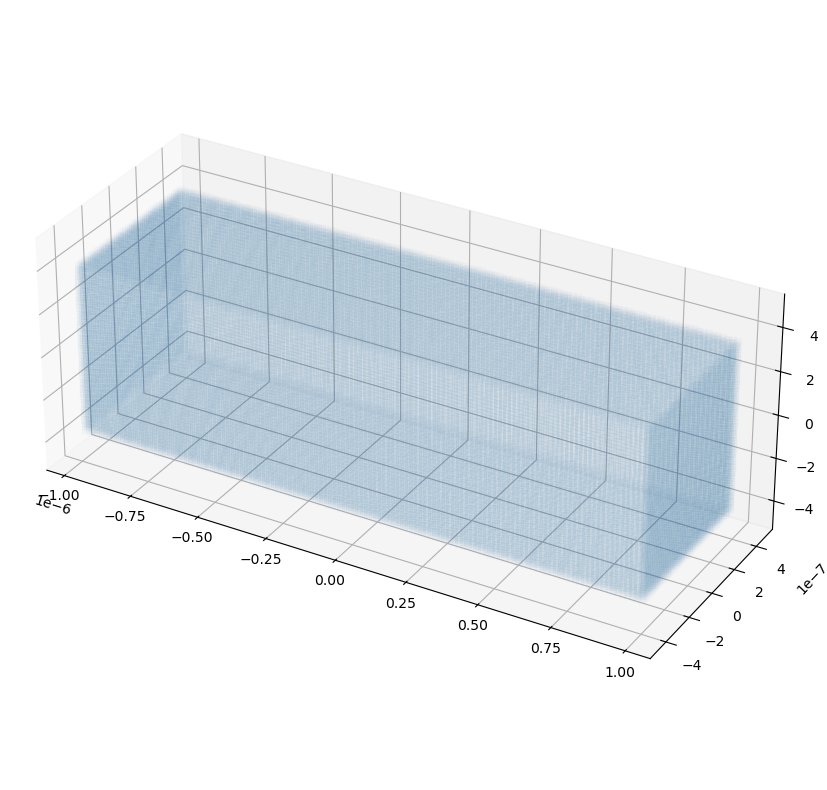

In [416]:
%matplotlib inline
a.draw3D(exclude_type=[0])

In [259]:
a.side_coord

[array([-3.2e-07, -3.1e-07, -3.0e-07, -2.9e-07, -2.8e-07, -2.7e-07,
        -2.6e-07, -2.5e-07, -2.4e-07, -2.3e-07, -2.2e-07, -2.1e-07,
        -2.0e-07, -1.9e-07, -1.8e-07, -1.7e-07, -1.6e-07, -1.5e-07,
        -1.4e-07, -1.3e-07, -1.2e-07, -1.1e-07, -1.0e-07, -9.0e-08,
        -8.0e-08, -7.0e-08, -6.0e-08, -5.0e-08, -4.0e-08, -3.0e-08,
        -2.0e-08, -1.0e-08,  0.0e+00,  1.0e-08,  2.0e-08,  3.0e-08,
         4.0e-08,  5.0e-08,  6.0e-08,  7.0e-08,  8.0e-08,  9.0e-08,
         1.0e-07,  1.1e-07,  1.2e-07,  1.3e-07,  1.4e-07,  1.5e-07,
         1.6e-07,  1.7e-07,  1.8e-07,  1.9e-07,  2.0e-07,  2.1e-07,
         2.2e-07,  2.3e-07,  2.4e-07,  2.5e-07,  2.6e-07,  2.7e-07,
         2.8e-07,  2.9e-07,  3.0e-07,  3.1e-07,  3.2e-07,  3.3e-07]),
 array([-6.4e-07, -6.3e-07, -6.2e-07, -6.1e-07, -6.0e-07, -5.9e-07,
        -5.8e-07, -5.7e-07, -5.6e-07, -5.5e-07, -5.4e-07, -5.3e-07,
        -5.2e-07, -5.1e-07, -5.0e-07, -4.9e-07, -4.8e-07, -4.7e-07,
        -4.6e-07, -4.5e-07, -4.4e-07, -4.3e-07